In [ ]:
import pandas as pd
import numpy as np
#from locale import atof, setlocale, LC_NUMERIC, LC_ALL
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import scipy
from scipy.stats import norm
#setlocale(LC_ALL, 'fr_FR.UTF-8')

# GetData

In [ ]:
import pandas as pd

class GetData:
    """ Read data from csv and load it in a dataframe
    accepted arguments : path to file , separator, chunksize and filter
    option to load csv by filtering on house type
    """

    def __init__(self,path ="../data/valeursfoncieres-2021.txt",sep = "|", chunksize = 100000):
        self.path = path
        self.sep = sep
        self.chunksize = chunksize


    def read_csv(self, filtering_column='Code type local', filter=[1]):
        """ pass option on which column to filter and filter value
        if several filter value, pass the as a list"""
        iter_csv = pd.read_csv(self.path,
                               sep=self.sep,
                               iterator=True,
                               chunksize=self.chunksize,
                               low_memory=False)
        self.df = pd.concat([
            chunk[chunk[filtering_column].isin(filter)] for chunk in iter_csv
        ])
        return self.df

    def enrichissement_coordinates(self,df):
        pass

    def enrichissement_insee(self,df):
        pass

    def loading_data_db (self,df):
        pass


In [ ]:
pd.set_option('display.max_columns', None)

# Preprocessing

Tout l'objectif de cette étape est de tirer le maximum du dataset, en reconstituant ce qui correspond réellement à une transaction. 
Nous avons réalisé cela en regroupant chaque transaction selon 3 clés : Parcelle / date / montant car ceux ci sont répété sur les lignes communes. 
Ensuite nous avons utilisé la methode apply qui pour chaque ligne du dataset aggrégé applique une fonction lambda dans laquelle on inséré une série dont les paramétres étaient la ligne aggrée. cela nous a permis de réaliser des fonctions plus complexes au niveau des aggrégats et de couvrir les différents cas ammenant à la mutltiplication des lignes 
Les cas plus complexes à retrouver sont par exemple la nature culture basée principale en se basant sur la superficie de celle ci (--- piste https://stackoverflow.com/questions/23394476/keep-other-columns-when-doing-groupby 
L'autre cas complexe était de compter le nombre de dépendances différentes ainsi que le nombre de maisons différentes au sein d'une même aggrégation -**ajouter cas ou on a plusieurs dépendances et plusieurs terrains -- trop complexe** : 
* #dépendance - count du terme dépendance valuecount sorted[0]  / nunique type local si nunique nat culture = 1 & len value count ==2 else count terme dependance valuecount sorted[0]   if len_value count ==2 else 0
* #maisons - count terme maison value count sorted [1] / nunqiue type local si nunique nat culture = 1 & len value count ==2 else count terme maison value count if len value_count ==2 else 0 

In [ ]:
#from house_prediction_package.data import GetData
import pandas as pd
import numpy as np
from datetime import datetime
from more_itertools import chunked
from scipy import stats

from sklearn.model_selection import train_test_split
#sans doute à supprimer au lancement final du modele
#from locale import atof, setlocale, LC_NUMERIC, LC_ALL

#setlocale(LC_ALL, 'fr_FR.UTF-8')

class Preprocessing :

    def __init__(self,df) :
        # self.df = get_data().read_csv()
        self.df = df

    def clean_columns(self,
                      columns=[
                          'Code service CH', 'Reference document',
                          '1 Articles CGI', '2 Articles CGI', '3 Articles CGI',
                          '4 Articles CGI', '5 Articles CGI', 'No Volume',
                          'Identifiant local'
                      ]):
        """ drop useless columns
        Customisation of columns to drop must be entered as a list
        """
        # suppression of 100% empty columns - these columns are officially not completed in this db
        self.df = self.df.drop(columns,axis=1)
        # suppression of columns poorly completed
        columns_to_drop = [column for column in self.df.columns if ((self.df[column].isnull().value_counts().sort_index()[0]/self.df.shape[0])*100) < 2 ]
        self.df= self.df.drop(columns_to_drop,axis=1)
        # replacement of , by . in numerical variables & deletion of non numrical caracters in num columns : 
        columns_num = ['Valeur fonciere', 'Surface Carrez du 1er lot', 'Nombre de lots',
        'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain']
        # transformation des , en . pour réaliser des opérations sur les nombres et suppressions des caracteres non numériques au sein de ces colonnes 
        for column in columns_num : 
            self.df[column]=self.df[column].apply(lambda s: s.replace(",",".") if isinstance(s,str) else s)
            self.df[column] = pd.to_numeric(self.df[column], errors = 'coerce')
        # suppression of nan value on target variable
        self.df= self.df.dropna(subset=['Valeur fonciere'])
        #self.df['Surface Carrez du 1er lot'] = self.df['Surface Carrez du 1er lot'].apply(
        #    lambda x: atof(x))        
        # pre processing avant groupby mais attention sortir valeures foncieres avant de mettre en POO
        ob_columns= self.df.dtypes[self.df.dtypes == 'O'].index
        num_columns = self.df.dtypes[(self.df.dtypes == 'int')
                                     | (self.df.dtypes == 'float')].index
        non_num_col = ['No disposition', 'No voie', 'Code postal', 'Code commune',
       'Prefixe de section', 'No plan','Code type local']
        num_columns = [value for value in num_columns if value not in non_num_col]
        for column in ob_columns :
            self.df[column]=self.df[column].replace(np.nan,'',regex=True)
        #à adapter in v2
        
        self.df[num_columns] = self.df[num_columns].apply(pd.to_numeric,
                                                              errors='coerce')
        
        #drop duplicates
        self.df = self.df.drop_duplicates().reset_index(drop= True)
        # by returning self, we can do method chaining like preprocessing(df).clean_columns().create_identifier()
        return self.df

    def create_identifier(self) :
        """ Create a 'unique' identifier allowing us to group several lines corresponding to a unique transaction
        """
        variables_to_clean = [
            "Code departement", "Code commune", "Prefixe de section",
            "Section", "No plan"
            ]
        size_variables= [2,3,3,2,4]
        for i,j in zip(variables_to_clean,size_variables):
            chunked_data = chunked(self.df[i], 10000, strict=False)
            values = {"Prefixe de section": '000'}
            self.df= self.df.fillna(value=values)
            if i == "Prefixe de section" :
                self.df[i] = self.df[i].apply(str).apply(lambda x: x[:3])
            new_variable = [
                str(value).replace(".","").zfill(j) for sublist in list(chunked_data)
                for value in sublist
            ]
            self.df[f"clean_{i.replace(' ','_').lower()}"] = new_variable
            self.df= self.df.drop([i],axis=1)
        self.df["parcelle_cadastrale"] = self.df[[
            "clean_code_departement", "clean_code_commune", "clean_prefixe_de_section",
            "clean_section", "clean_no_plan"]].apply(lambda x: "".join(x), axis=1)
        self.df["parcelle_cad_section"]=self.df["parcelle_cadastrale"].str[:10]
        self.df = self.df.drop([
            "clean_prefixe_de_section", "clean_section", "clean_no_plan"
        ], axis = 1)
        return self.df

    def aggregate_transactions(self):
        self.df = self.df.groupby(["parcelle_cad_section","Date mutation","Valeur fonciere"], as_index= False).apply(lambda x : pd.Series({
            "num_voie" : x["No voie"].max()
            ,"B_T_Q" : x["B/T/Q"].max()
            ,"type_de_voie": x["Type de voie"].max()
            ,"voie": x["Voie"].max()
            ,"code_postal": x["Code postal"].max()
            ,"commune": max(x["Commune"])
            ,"clean_code_departement": x["clean_code_departement"].max()
            ,"clean_code_commune": max(x["clean_code_commune"])
            ,"surface_carrez_lot_1" :  x["Surface Carrez du 1er lot"].sum()/((x["Surface reelle bati"].count()/x["Nature culture"].nunique()))
            ,"Nb_lots": x["Nombre de lots"].max()
            ,"surface_terrain" : ((x["Surface terrain"].sum()/x["Surface reelle bati"].count()) if (int(x["Surface terrain"].nunique()) ==1 and int(x["Nature culture"].nunique()) == 1 )else x["Surface terrain"].sum())
            ,"surface_reelle_bati" : (x["Surface reelle bati"].sum()/(x["Surface reelle bati"].count()/x["Type local"].nunique()) if (int(x["Nature culture"].nunique() > 1)) else x["Surface reelle bati"].sum())
            ,"nb_pieces_principales" : (x["Nombre pieces principales"].sum()/(x["Surface reelle bati"].count()/x["Type local"].nunique()) if int(x["Nature culture"].nunique()) > 1 else x["Nombre pieces principales"].sum())      
            ,"dependance" : x["Type local"].unique()
            ,"main_type_terrain" : x["Nature culture"].max()
            ,"parcelle_cadastrale": x["parcelle_cadastrale"].max()}))
        self.df = self.df.replace(np.inf, np.nan)
        #drop rows with only dependances transactions as we focus on houses
        self.df = self.df[self.df.dependance.apply(
            lambda x: x.all() != "Dépendance")].reset_index(drop=True)
        self.df["dependance"] = self.df.dependance.apply(sorted, 1)
        self.df[["Dependance",
                 "Maison"]] = pd.DataFrame(self.df.dependance.tolist(),
                                           index=self.df.index)
        self.df["Dependance"] = [1 if value =="Dépendance"else 0 for value in self.df["Dependance"]]
        self.df= self.df.drop(["dependance","Maison"],axis =1)
        return self.df

    # to do : function calling enrichissement from data


    def feature_generation (self):
        # convert the 'Date' column to datetime format
        self.df["month"] = pd.to_datetime(
            self.df["Date mutation"],format="%d/%m/%Y").dt.month
        self.df= self.df.drop(["Date mutation"], axis = 1)
        ## attention à ne faire qu'après avoir enrichi avec variables insee
        dict_type_voie = dict()
        for value in self.df["type_de_voie"].value_counts()[self.df["type_de_voie"].value_counts()<300 ].index.values :
            dict_type_voie[value] = "Autres"
        self.df=self.df.replace({"type_voie" : dict_type_voie})
        self.df["type_de_voie"]= self.df["type_de_voie"].replace(np.nan,'vide')
        return self.df

    def zscore (self) :
        # Calculate the z-score from scratch
        #self.df['Valeur fonciere']= df['Valeur fonciere'].apply(lambda x: atof(x))
        standard_deviation = self.df["Valeur fonciere"].std(ddof=0)
        mean_value = self.df["Valeur fonciere"].mean()
        zscores = [(value - mean_value) / standard_deviation
                for value in self.df["Valeur fonciere"]]
        self.df["zscores"]= zscores
        # absolute value of zscore and if sup x then 1  :
        self.df["outlier"] = [
            1 if (abs(value) > 3) else 0 for value in self.df["zscores"]
        ]
        self.df=self.df[self.df["outlier"] == 0].reset_index(drop=True)
        self.df = self.df.drop(["zscores","outlier"], axis = 1)
        return self.df

    def split_x_y (self):
        columns_model = ["type_de_voie",
            "clean_code_departement",
            "clean_code_commune",
            "code_postal",
            "surface_terrain",
            "surface_reelle_bati", "nb_pieces_principales",
            "main_type_terrain",  "Dependance",
            "month"]
        # Séparation des variables catégorielles et numériques
        categorical_features = [
            "type_de_voie", "clean_code_departement", "clean_code_commune",
            "code_postal", "main_type_terrain", "Dependance", "month"
        ]
        numerical_features = [
            "surface_terrain", "surface_reelle_bati", "nb_pieces_principales"
        ]
        for column in categorical_features:
            self.df[column] = self.df[column].replace(np.nan, "").apply(str)
        X = self.df[columns_model]
        y =self.df["Valeur fonciere"]
        # selection des variables
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.33,
                                                            random_state=42)
        return self.df,categorical_features, numerical_features, X_train, X_test, y_train, y_test


# Pipeline 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

from sklearn import pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#from house_prediction_package.preprocessing import Preprocessing
#from house_prediction_package.data import GetData


class Pipeline :

    def __init__(self, df):
        self.df = df
        # self.categorical_features = categorical_features
        # self.numerical_features = numerical_features
        # self.X_train = X_train
        # self.y_train = y_train
        # option 2
        #appeler les méthodes
        self.df, self.categorical_features, self.numerical_features, self.X_train, self.X_test, self.y_train, self.y_test = Preprocessing(
            df).feature_generation().zscore().split_x_y()

    def pipeline(self):
        # création des pipelines de pré-processing pour les variables numériques et catégorielles
        #ajout d'un parametre pour gerer les valeures non connues dans onehotencoder - il les passe à 0(autres options disponibles)
        numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())
        categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
        preprocessor = make_column_transformer(
            (numerical_pipeline, self.numerical_features),
            (categorical_pipeline, self.categorical_features))
        model = make_pipeline(preprocessor, LinearRegression())
        fitted_model = model.fit(self.X_train, self.y_train)
        return fitted_model, self.X_train, self.y_train,self.X_test, self.y_test


# Zone de tests

## Test model sans aggrégation 

In [ ]:
df = GetData().read_csv()

In [ ]:
df,categorical_features, numerical_features, X_train, X_test, y_train, y_test = Preprocessing(df).split_x_y()

In [ ]:
numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
preprocessor = make_column_transformer(
            (numerical_pipeline, numerical_features),
            (categorical_pipeline, categorical_features))
model = make_pipeline(preprocessor, LinearRegression())
fitted_model = model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

test_y_hat = fitted_model.predict(X_test)
print('Score r²: ', fitted_model.score(X_test, y_test))
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - y_test)))
print("Residual  of squares (MSE): %.2f" % np.mean((test_y_hat - y_test)**2))
print("R2-score: %.2f" % r2_score(test_y_hat, y_test))

In [ ]:
import pickle
# save the model to disk
filename = 'house_model_wo_aggregations.sav'
pickle.dump(fitted_model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## Test model maison avec aggrégation 

In [ ]:
df= GetData().read_csv()

In [ ]:
df = Preprocessing(df).clean_columns()

In [ ]:
df= Preprocessing(df).create_identifier()

In [ ]:
df = Preprocessing(df).aggregate_transactions()

In [ ]:
df.to_csv("aggregatedfile_houses.csv", sep='|', encoding="utf-8") 

In [ ]:
df = Preprocessing(df).feature_generation()

In [ ]:
df = Preprocessing(df).zscore() 

In [ ]:
df,categorical_features, numerical_features, X_train, X_test, y_train, y_test =  Preprocessing(df).split_x_y()

In [ ]:
numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
preprocessor = make_column_transformer(
            (numerical_pipeline, numerical_features),
            (categorical_pipeline, categorical_features))
model = make_pipeline(preprocessor, LinearRegression())
fitted_model = model.fit(X_train, y_train)

In [ ]:
X_test[X_test.surface_terrain== np.inf]

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math
X_test = X_test.replace(np.inf, np.nan)
test_y_hat = fitted_model.predict(X_test)
print('Score r²: ', fitted_model.score(X_test, y_test))
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - y_test)))
print("Residual  of squares (MSE): %.2f" % np.mean((test_y_hat - y_test)**2))
print("R(MSE): %.2f" % math.sqrt(np.mean((test_y_hat - y_test)**2)))
print("R2-score: %.2f" % r2_score(test_y_hat, y_test))

Score r²:  0.4806680640761509      
Mean absolute error: 83460.59     
Residual  of squares (MSE): 46023819610.40     
R(MSE): 214531.63    
R2-score: -0.02    

In [ ]:
import pickle
# save the model to disk
filename = 'house_model_aggregations.sav'
pickle.dump(fitted_model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## test model maison/dep with aggregations

In [ ]:
df= GetData().read_csv(filter=[1,3])

In [ ]:
df = Preprocessing(df).clean_columns()

In [ ]:
df= Preprocessing(df).create_identifier()

In [ ]:
df = Preprocessing(df).aggregate_transactions()

df.to_csv("aggregatedfile_houses_dep.csv", sep='|', encoding="utf-8")

In [ ]:
df.info()

In [ ]:
df = Preprocessing(df).feature_generation()

df = Preprocessing(df).zscore() 

df,categorical_features, numerical_features, X_train, X_test, y_train, y_test  = Preprocessing(df).split_x_y()

numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
preprocessor = make_column_transformer(
            (numerical_pipeline, numerical_features),
            (categorical_pipeline, categorical_features))
model = make_pipeline(preprocessor, LinearRegression())

In [ ]:
fitted_model = model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

test_y_hat = fitted_model.predict(X_test)
print('Score r²: ', fitted_model.score(X_test, y_test))
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - y_test)))
print("Residual  of squares (MSE): %.2f" % np.mean((test_y_hat - y_test)**2))
print("R(MSE): %.2f" % math.sqrt(np.mean((test_y_hat - y_test)**2)))
print("R2-score: %.2f" % r2_score(test_y_hat, y_test))

import pickle
# save the model to disk
filename = 'house_dep_model_aggregations.sav'
pickle.dump(fitted_model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## Enrichissement lat long iris insee

In [ ]:
import pandas as pd
import numpy as np

On lit le nouveau csv aggrégé qui nous a fait réduire le nombre de lignes de 1 M à 430 K 
Ensuite, on utilise l'api ban 
enrichissement 20 h trop long
test avec csv 

In [ ]:
df = pd.read_csv("aggregatedfile_houses_dep.csv", sep = "|", index_col=0,dtype ={"parcelle_cad_section":  str  
,"Date mutation": object 
,"Valeur fonciere"  : np.float32
,"num_voie" : np.float32
,"B_T_Q" : object 
,"type_de_voie": object 
,"voie":  object 
,"code_postal": np.float64
,"commune": object 
,"clean_code_departement": object 
,"clean_code_commune": object  
,"surface_carrez_lot_1": np.float32
,"Nb_lots": np.int32  
,"surface_terrain":  np.float32
,"surface_reelle_bati":np.float32
,"nb_pieces_principales":np.float32
,"main_type_terrain":object 
,"parcelle_cadastrale": object})

In [ ]:
# Using DataFrame.apply() and lambda function\n",
# df_adresses['No voie']= df_adresses['No voie'].astype(int)\n",
# on ne peut pas passer les num voies/code postaux  en int/string sans d'abord nettoyer les nan values \n",
df["voie"]=df["voie"].replace(" ","+")
df["adresse"] = df[["num_voie", "type_de_voie", "voie"]].apply(lambda x: "+".join(x.astype(str)), axis=1)
#df['clean_code_commune'] = df[["clean_code_departement","clean_code_commune"]].apply(lambda x: "".join(x.astype(str)), axis=1)


In [ ]:
full_code_commun =[]
for dep,comm in zip(df["clean_code_departement"],df['clean_code_commune']):
    if len(dep) == 3: 
        full_code_commun.append(dep + comm[1:3])
    else : 
        full_code_commun.append(dep + comm)

In [ ]:
df['clean_code_commune'] = full_code_commun

In [ ]:
df["adresse"]= df[["adresse","clean_code_commune"]].apply(lambda x : "&citycode=".join(x.astype(str)),axis=1)

In [ ]:
df.tail()

In [ ]:
n = 2000  #chunk row size
list_df = [df[i:i+n] for i in range(0,df.shape[0],n)]
# reassemblage by pd.concat possible mais on s'en fiche car on va fonctionner sur des'petits df' 
#pour enrichissement puis insertion en bdd

In [1]:
import requests
from datetime import datetime

In [ ]:
list_df[0]['adresse']

In [ ]:
#long=[]
#lat= []

In [ ]:
test = 'ok'
start_time = datetime.now()

for j in range(2,len(list_df)):
    if test == 'ok':
        for value in list_df[j]['adresse']:
            try : 
                long.append(requests.get(f'http://localhost:7878/search?q={value}').json()['features'][0]['geometry']['coordinates'][0])
                lat.append(requests.get(f'http://localhost:7878/search/?q={value}').json()['features'][0]['geometry']['coordinates'][1])
            except  : 
                lat.append('not found')
                long.append('not found')            
    test= input(f"iteration {j}, pour passer à l'itération {j+1} taper ok  : ")
    f=j
end_time = datetime.now()
print('Duration: {} et arret à la {}'.format(end_time - start_time, f))

iteration 2, pour passer à l'itération 3 taper ok  : ok    
iteration 3, pour passer à l'itération 4 taper ok  : ok    
iteration 4, pour passer à l'itération 5 taper ok  : ok    
iteration 5, pour passer à l'itération 6 taper ok  : ok    
iteration 6, pour passer à l'itération 7 taper ok  : ok    
iteration 7, pour passer à l'itération 8 taper ok  : ok    
iteration 8, pour passer à l'itération 9 taper ok  : ok    
iteration 9, pour passer à l'itération 10 taper ok  : ok    
iteration 10, pour passer à l'itération 11 taper ok  : ok    
iteration 12, pour passer à l'itération 13 taper ok  : ok    
iteration 13, pour passer à l'itération 14 taper ok  : ko    

In [ ]:
import pickle
# save the model to disk
filename = 'lat.sav'
pickle.dump(lat, open(filename, 'wb'))
filename2= 'long.sav'
pickle.dump(lat, open(filename2, 'wb'))

In [ ]:
requests.get("http://localhost:7878/search/?q=27.0+RUE+DES PINS&citycode=97424").json()

In [ ]:
df

## Récupération CSV enrichi en masse et récupération IRIS

In [ ]:
df = pd.read_csv('../data/geolocgeocoded.csv', sep='|', index_col=0, dtype= {
"num_voie" : np.float32
,"type_de_voie": object 
,"voie":  object 
,"commune": object 
,"clean_code_commune": object, "latitude": np.float32, "longitude": np.float32, "result_score" : np.float32 })

In [ ]:
df = df[["num_voie","type_de_voie","voie","commune","clean_code_commune","latitude", "longitude","result_score"]]

In [ ]:
df

In [ ]:
import requests
from datetime import datetime

pour lancer pyris : 
1. d'abord activer lancer postgres sql 
 * sudo service postgresql start
2.  puis depuis le dossier  house pred /api / pyris : 
 * gunicorn -b 127.0.0.1:5555 pyris.api.run:app 

Qu'est ce qu'IRIS : "Afin de préparer la diffusion du recensement de la population de 1999, l'INSEE avait développé un découpage du territoire en mailles de taille homogène appelées IRIS2000. Un sigle qui signifiait « Ilots Regroupés pour l'Information Statistique » et qui faisait référence à la taille visée de 2 000 habitants par maille élémentaire." source : https://www.insee.fr/fr/metadonnees/definition/c1523    
API fonctionne avec Postgis ( extension de postgres pour les données géospatiales).    
Pour qu'elle fonctionne, j'ai donc télécharger les fichiers suivants : 
 * contours iris 
 * références iris 
 * divers statistiques INSEE à l'échelon IRIS 
     * statistiques activités -
     * statistiques démographiques - ménages et evol pop 
     * statistiques scolaires
     * statistiques logements 

In [ ]:
df['coordinates'] = df[["latitude","longitude"]].apply(lambda x : "&lon=".join(x.astype(str)),axis=1)

In [ ]:
df = df.drop_duplicates(subset=['coordinates'])

In [ ]:
# api url 
url = "http://127.0.0.1:5555/api/coords?geojson=false&lat="

In [ ]:
n = 50000  #chunk row size
list_df = [df[i:i+n] for i in range(0,df.shape[0],n)]
# reassemblage by pd.concat possible mais on s'en fiche car on va fonctionner sur des'petits df' 
#pour enrichissement puis insertion en bdd

In [ ]:
IRIS = []

In [ ]:
test = 'ok'
start_time = datetime.now()

for j in range(0,len(list_df)):
    if test == 'ok':
        for value in list_df[j]['coordinates']:
            try : 
                IRIS.append(requests.get(f'{url}{value}').json()['complete_code'])
            except  : 
                IRIS.append('not found')
    test= input(f"iteration {j}, pour passer à l'itération {j+1} taper ok  : ")
    f=j
end_time = datetime.now()
print('Duration: {} et arret à la {}'.format(end_time - start_time, f))

In [ ]:
IRIS= pickle.load(open(filename, 'rb'))

In [ ]:
df['IRIS']= IRIS

In [ ]:
df[df['IRIS'] =='not found']

Recherche par ville sur les valeures non trouvées

In [ ]:
for index, value in df[df['IRIS'] =='not found'].iterrows() : 
    print('######',index,'*****', value['clean_code_commune'])
    try :
        df.at[index,'IRIS'] = requests.get(f"http://127.0.0.1:5555/api/city/code/{value['clean_code_commune']}").json()[0]
    except : 
        continue

## Recherche api open data soft 


les dernieres valeures non trouvées appartiennent aux dom tom Martinique Guadeloupe Guyanne et Réunion

In [ ]:
url ="https://data.opendatasoft.com/api/records/1.0/search/?dataset=iris-millesime-france%40lareunion&q="

In [ ]:
/api/records/1.0/search/?dataset=iris-millesime-france&q=97101&sort=year&facet=com_arm_name 

## appel d'un api externe pour la réunion : 
** ajouter un prefiltre dans le code **

https://data.opendatasoft.com/explore/dataset/iris-millesime-france%40lareunion/api/?disjunctive.reg_name&disjunctive.dep_name&disjunctive.arrdep_name&disjunctive.ze2020_name&disjunctive.bv2012_name&disjunctive.epci_name&disjunctive.ept_name&disjunctive.com_name&disjunctive.com_arm_name&disjunctive.iris_name&sort=year&q=97424&geofilter.polygon=&geofilter.distance=

In [ ]:
for index, value in df[df['IRIS'] =='not found'].iterrows() : 
    print('######',index,'*****', value['clean_code_commune'])
    try :
        df.at[index,'IRIS'] = requests.get(f"{url}{value['clean_code_commune']}&sort=year&facet=com_arm_name").json()['records'][0]['fields']['iris_code']
    except : 
        continue

## Appel d'un api externe pour la guadeloupe 


https://regionguadeloupe.opendatasoft.com/explore/dataset/iris-millesime-france/information/?disjunctive.reg_name&disjunctive.dep_name&disjunctive.arrdep_name&disjunctive.ze2020_name&disjunctive.bv2012_name&disjunctive.epci_name&disjunctive.ept_name&disjunctive.com_name&disjunctive.com_arm_name&disjunctive.iris_name&sort=year&q=97101&dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6ImlyaXMtbWlsbGVzaW1lLWZyYW5jZSIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUucmVnX25hbWUiOnRydWUsImRpc2p1bmN0aXZlLmRlcF9uYW1lIjp0cnVlLCJkaXNqdW5jdGl2ZS5hcnJkZXBfbmFtZSI6dHJ1ZSwiZGlzanVuY3RpdmUuemUyMDIwX25hbWUiOnRydWUsImRpc2p1bmN0aXZlLmJ2MjAxMl9uYW1lIjp0cnVlLCJkaXNqdW5jdGl2ZS5lcGNpX25hbWUiOnRydWUsImRpc2p1bmN0aXZlLmVwdF9uYW1lIjp0cnVlLCJkaXNqdW5jdGl2ZS5jb21fbmFtZSI6dHJ1ZSwiZGlzanVuY3RpdmUuY29tX2FybV9uYW1lIjp0cnVlLCJkaXNqdW5jdGl2ZS5pcmlzX25hbWUiOnRydWUsInNvcnQiOiJ5ZWFyIiwicSI6Im1hcmllIGdhbGFudGUgZ3JhbmQgYm91cmciLCJyZWZpbmUuemUyMDIwX25hbWUiOiJNYXJpZS1HYWxhbnRlIiwicmVmaW5lLmNvbV9uYW1lIjoiR3JhbmQtQm91cmcifX0sImNoYXJ0cyI6W3siYWxpZ25Nb250aCI6dHJ1ZSwidHlwZSI6ImxpbmUiLCJmdW5jIjoiQ09VTlQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiIjRUQ5QTlBIn1dLCJ4QXhpcyI6InllYXIiLCJtYXhwb2ludHMiOiIiLCJ0aW1lc2NhbGUiOiJ5ZWFyIiwic29ydCI6IiJ9XSwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D

In [ ]:
url ="https://regionguadeloupe.opendatasoft.com/api/records/1.0/search/?dataset=iris-millesime-france&q="

In [ ]:
for index, value in df[df['IRIS'] =='not found'].iterrows() : 
    print('######',index,'*****', value['clean_code_commune'])
    if value['clean_code_commune'][0:3] == '971' :
        try :
            df.at[index,'IRIS'] = requests.get(f"{url}{value['clean_code_commune']}&sort=year&facet=com_arm_name").json()['records'][0]['fields']['iris_code']
        except : 
            continue

## appel d'un autre api pour martinique et guyanne 


https://public.opendatasoft.com/explore/dataset/georef-france-iris/api/?disjunctive.reg_name&disjunctive.dep_name&disjunctive.arrdep_name&disjunctive.ze2020_name&disjunctive.bv2012_name&disjunctive.epci_name&disjunctive.ept_name&disjunctive.com_name&disjunctive.com_arm_name&disjunctive.iris_name&sort=year&q=97201

In [ ]:
url="https://public.opendatasoft.com/api/records/1.0/search/?dataset=georef-france-iris&q="

In [ ]:
for index, value in df[df['IRIS'] =='not found'].iterrows() : 
    print('######',index,'*****', value['clean_code_commune'])
    try :
        df.at[index,'IRIS'] = requests.get(f"{url}{value['clean_code_commune']}&sort=year&facet=com_arm_name").json()['records'][0]['fields']['iris_code']
    except : 
        continue

## reconstitution df

In [ ]:
df_init = pd.read_csv('../data/geolocgeocoded.csv', sep='|', index_col=0, dtype= {
"num_voie" : np.float32
,"type_de_voie": object 
,"voie":  object 
,"commune": object 
,"clean_code_commune": object, "latitude": np.float32, "longitude": np.float32, "result_score" : np.float32 })

In [ ]:
df_init= df_init[["num_voie","type_de_voie","voie","commune","clean_code_commune","latitude", "longitude","result_score"]]

Pour code final garder plutot l'id de résultat qui correspond à lat et long trouvé et dédoublonner selon cet id

In [ ]:
df_init['coordinates'] = df_init[["latitude","longitude"]].apply(lambda x : "&lon=".join(x.astype(str)),axis=1)

In [ ]:
df_init = df_init.merge(df[['coordinates','IRIS']], left_on='coordinates', right_on='coordinates',
          suffixes=('_left', '_right'),  how='left')

In [ ]:
df_init.to_csv("aggregatedfile_houses_dep_WITH_IRIS.csv", sep='|', encoding="utf-8")

## Enrichissement variables INSEE sur CODES IRIS


In [ ]:
import requests
from datetime import datetime

In [ ]:
df= pd.read_csv('aggregatedfile_houses_dep_WITH_IRIS.csv', sep='|', index_col=0, dtype= {
"num_voie" : np.float32
,"type_de_voie": object 
,"voie":  object 
,"commune": object 
,"clean_code_commune": object, "latitude": np.float32, "longitude": np.float32, "result_score" : np.float32, 
'IRIS': object})

In [ ]:
df

In [ ]:
#url = "http://127.0.0.1:5555/api/insee/activite/distribution/"

In [ ]:
#inititing lists : 
actif_15_24 = []
actif_25_54 = []
actif_55_64 = []
chomage_15_24 = []
chomage_25_54 = []
chomage_55_64 = []
taux_chomage_15_24 = []
taux_chomage_25_54 = []
taux_chomage_55_64 = []

In [ ]:
for value in df.IRIS.unique() : 
    try:
        result = requests.get(f'http://127.0.0.1:5555/api/insee/activite/distribution/{value}?by=age').json()['data']
        for variable in result.keys():
            try: 
                if variable == 'taux_chomage_15_24':
                    taux_chomage_15_24.append(result[variable])
                elif variable == 'taux_chomage_25_54':
                    taux_chomage_25_54.append(result[variable])
                elif variable == 'taux_chomage_55_64':
                    taux_chomage_55_64.append(result[variable])
            except : 
                if variable == 'taux_chomage_15_24':
                    taux_chomage_15_24.append('not_found')
                elif variable == 'taux_chomage_25_54':
                    taux_chomage_25_54.append('not found')
                elif variable == 'taux_chomage_55_64':
                    taux_chomage_55_64.append('not_found')
    except: 
        taux_chomage_15_24.append('not_found')
        taux_chomage_25_54.append('not found')
        taux_chomage_55_64.append('not_found')

In [ ]:
#requests.get(f'http://127.0.0.1:5555/api/insee/activite/distribution/010010000?by=age').json()['data'].keys()

In [ ]:
df_stat=pd.DataFrame({'IRIS': df.IRIS.unique(),'taux_chomage_15_24':taux_chomage_15_24,"taux_chomage_25_54":taux_chomage_25_54,"taux_chomage_55_64":taux_chomage_55_64 })

In [ ]:
df_stat

In [ ]:
main_residence_30m2= []
main_residence_30_40m2= []
main_residence_40_60m2= []
main_residence_60_80m2= []
main_residence_80_100m2= []
main_residence_100_120m2= []
main_residence_120m2= []

In [ ]:
for value in df_stat['IRIS'] : 
    try:
        result= requests.get(f'http://127.0.0.1:5555/api/insee/logement/distribution/{value}?by=area').json()['data']
        for variable in result.keys():
            try: 
                if variable == 'main_residence_30m2':
                    main_residence_30m2.append(result[variable])
                elif variable == 'main_residence_30_40m2':
                    main_residence_30_40m2.append(result[variable])
                elif variable == 'main_residence_40_60m2':
                    main_residence_40_60m2.append(result[variable])
                elif variable == 'main_residence_60_80m2':
                    main_residence_60_80m2.append(result[variable])
                elif variable == 'main_residence_80_100m2':
                    main_residence_80_100m2.append(result[variable])
                elif variable == 'main_residence_100_120m2':
                    main_residence_100_120m2.append(result[variable])
                elif variable == 'main_residence_120m2':
                    main_residence_120m2.append(result[variable])
            except : 
                if variable == 'main_residence_30m2':
                    main_residence_30m2.append('not_found')
                elif variable == 'main_residence_30_40m2':
                    main_residence_30_40m2.append('not found')
                elif variable == 'main_residence_40_60m2':
                    main_residence_40_60m2.append('not_found')
                elif variable == 'main_residence_60_80m2':
                    main_residence_60_80m2.append('not found')
                elif variable == 'main_residence_80_100m2':
                    main_residence_80_100m2.append('not_found')
                elif variable == 'main_residence_30_40m2':
                    main_residence_100_120m2.append('not found')
                elif variable == 'main_residence_120m2':
                    main_residence_120m2.append('not_found')
    except: 
        main_residence_30m2.append('not_found')
        main_residence_30_40m2.append('not found')
        main_residence_40_60m2.append('not_found')
        main_residence_60_80m2.append('not_found')
        main_residence_80_100m2.append('not found')
        main_residence_100_120m2.append('not_found')
        main_residence_120m2.append('not_found')

In [ ]:
df_stat['main_residence_30m2'] = main_residence_30m2
df_stat['main_residence_30_40m2'] = main_residence_30_40m2
df_stat['main_residence_40_60m2'] = main_residence_40_60m2
df_stat['main_residence_60_80m2'] = main_residence_60_80m2
df_stat['main_residence_80_100m2'] = main_residence_80_100m2
df_stat['main_residence_100_120m2'] = main_residence_100_120m2
df_stat['main_residence_120m2'] = main_residence_120m2

In [ ]:
df_stat.to_csv("IRIS_STATS_INSEE.csv", sep='|', encoding="utf-8")

In [ ]:
df_stat= pd.read_csv('IRIS_STATS_INSEE.csv', sep='|', index_col=0)

In [ ]:
df_stat

### Enrichissement logement 

In [ ]:
logement= []
main_residence= []
second_residence= []
unoccupied= []
house= []
appartment= []

In [ ]:
requests.get(f'http://127.0.0.1:5555/api/insee/logement/010040201').json()

In [ ]:
for value in df_stat['IRIS']: 
    try:
        result= requests.get(f'http://127.0.0.1:5555/api/insee/logement/{value}').json()
        for variable in result.keys():
            try: 
                if variable == 'logement':
                    logement.append(result[variable])
                elif variable == 'main_residence':
                    main_residence.append(result[variable])
                elif variable == 'second_residence':
                    second_residence.append(result[variable])
                elif variable == 'unoccupied':
                    unoccupied.append(result[variable])
                elif variable == 'house':
                    house.append(result[variable])
                elif variable == 'appartment':
                    appartment.append(result[variable])
            except : 
                if variable == 'logement':
                    logement.append('not_found')
                elif variable == 'main_residence':
                    main_residence.append('not found')
                elif variable == 'second_residence':
                    second_residence.append('not_found')
                elif variable == 'unoccupied':
                    unoccupied.append('not found')
                elif variable == 'house':
                    house.append('not_found')
                elif variable == 'appartment':
                    appartment.append('not found')
    except: 
        logement.append('not_found')
        main_residence.append('not found')
        second_residence.append('not_found')
        unoccupied.append('not_found')
        house.append('not found')
        appartment.append('not_found')

In [ ]:
df['IRIS'].nunique()

In [ ]:
df[~df['IRIS'].isin(df_stat['IRIS'])]

### Liste des bases de données niveau IRIS 
https://www.insee.fr/fr/information/2383389 :


* spécial Filosofi : https://www.insee.fr/fr/statistiques/6049648#dictionnaire

* https://www.insee.fr/fr/statistiques/5650714#consulter

* https://www.insee.fr/fr/statistiques/5650712#dictionnaire

* https://www.insee.fr/fr/statistiques/5650708#dictionnaire

#### analyse data logement - variables à garder :
https://www.insee.fr/fr/statistiques/5650749#dictionnaire
 92 variables - variables suivantes gardées : 
 - variables inter logements - nbre de logements,logements vacants nbre type apparte, nbre hlm, nbre maisons, nbre residences princ (je n'ai pas pris le nombre de résidence principale de type maison ou appartements redondant avec données déjà prise : nbre maison, nbre appartements)
 - variables intra logements - nbre pieces, superficies, garage....
 - variables ménages - residence par propio /locataires , emménagement 2 ans , 4 ans e
 
choix de ne pas prendre les variables sur période de fabrication des logements

In [ ]:
df_stat= pd.read_csv('../data/base-ic-logement-2018.CSV',sep=';', dtype= {
"IRIS" : object
,"COM": object 
,"TYP_IRIS":  object 
,"MODIF_IRIS": object 
,"LAB_IRIS": object
,'P18_RP_ELEC': np.float32, 'P18_RP_EAUCH':np.float32, 'P18_RP_BDWC':np.float32, 'P18_RP_CHOS':np.float32,
       'P18_RP_CLIM':np.float32, 'P18_RP_TTEGOU':np.float32, 'P18_RP_GARL':np.float32, 'P18_RP_VOIT1P':np.float32,
       'P18_RP_VOIT1':np.float32, 'P18_RP_VOIT2P':np.float32, 'P18_RP_HABFOR':np.float32, 'P18_RP_CASE':np.float32,
       'P18_RP_MIBOIS':np.float32,'P18_RP_MIDUR':np.float32})

In [ ]:
df_stat.columns

In [ ]:
df_stat[['IRIS']].isnull().value_counts()

In [ ]:
df_stat=df_stat[['IRIS', 'LAB_IRIS','P18_LOG', 'P18_RP', 'P18_RSECOCC', 'P18_LOGVAC', 'P18_MAISON', 'P18_APPART','P18_RP_1P', 
         'P18_RP_2P', 'P18_RP_3P', 'P18_RP_4P', 'P18_RP_5PP','P18_RP_M30M2', 'P18_RP_3040M2', 'P18_RP_4060M2',
       'P18_RP_6080M2', 'P18_RP_80100M2', 'P18_RP_100120M2', 'P18_RP_120M2P','P18_RP_GARL','P18_RP_PROP', 
         'P18_RP_LOC', 'P18_RP_LOCHLMV','P18_RP_GRAT','P18_MEN_ANEM0002', 'P18_MEN_ANEM0204',
       'P18_MEN_ANEM0509', 'P18_MEN_ANEM10P']]

In [ ]:
df_stat[['P18_LOG','P18_RP','P18_RP_GARL','P18_RP_PROP', 'P18_RP_GRAT',
         'P18_RP_LOC', 'P18_RP_LOCHLMV','P18_MEN_ANEM0002', 'P18_MEN_ANEM0204',
       'P18_MEN_ANEM0509', 'P18_MEN_ANEM10P']]

In [ ]:
def columns_featuring (df) : 
    df["Taux_RP"] = df["P18_RP"]/df["P18_LOG"]
    df["Taux_LV"] = df["P18_LOGVAC"]/df["P18_LOG"]
    df["Taux_MAI"] = df["P18_MAISON"]/df["P18_LOG"]
    # APPARTEMENT PAS UTILE CAR SOIT MAISON SOIT APPARTEMENT
    #nb pieces
    df["Taux_RP_1P"] = df["P18_RP_1P"]/df["P18_RP"]
    df["Taux_RP_2P"] = df["P18_RP_2P"]/df["P18_RP"] 
    df["Taux_RP_3P"] = df["P18_RP_3P"]/df["P18_RP"]    
    df["Taux_RP_4P"] = df["P18_RP_4P"]/df["P18_RP"] 
    df["Taux_RP_5P"] = df["P18_RP_5PP"]/df["P18_RP"] 
    #superficie
    df["Taux_RP_30"] = df["P18_RP_M30M2"]/df["P18_RP"]
    df["Taux_RP_40"] = df["P18_RP_3040M2"]/df["P18_RP"] 
    df["Taux_RP_60"] = df["P18_RP_4060M2"]/df["P18_RP"]    
    df["Taux_RP_80"] = df["P18_RP_6080M2"]/df["P18_RP"] 
    df["Taux_RP_100"] = df["P18_RP_80100M2"]/df["P18_RP"] 
    df["Taux_RP_120"] = df["P18_RP_100120M2"]/df["P18_RP"] 
    df["Taux_RP_P120"] = df["P18_RP_120M2P"]/df["P18_RP"] 
    #occupation
    df["Taux_RP_GAR"] = df["P18_RP_GARL"]/df["P18_RP"]
    df["Taux_RP_PROPRIO"] = df["P18_RP_PROP"]/df["P18_RP"] 
    df["Taux_RP_GRATUIT"] = df["P18_RP_GRAT"]/df["P18_RP"]    
    df["Taux_RP_LOC"] = df["P18_RP_LOC"]/df["P18_RP"] 
    df["Taux_RP_HML"] = df["P18_RP_LOCHLMV"]/df["P18_RP"] 
    df["Taux_RP_AM02"] = df["P18_MEN_ANEM0002"]/df["P18_RP"] 
    df["Taux_RP_AM04"] = df["P18_MEN_ANEM0204"]/df["P18_RP"] 
    df["Taux_RP_AM09"] = df["P18_MEN_ANEM0509"]/df["P18_RP"] 
    df["Taux_RP_AM09P"] = df["P18_MEN_ANEM10P"]/df["P18_RP"]  
    df =df.drop(['P18_LOG', 'P18_RP', 'P18_RSECOCC', 'P18_LOGVAC', 'P18_MAISON', 'P18_APPART','P18_RP_1P', 
         'P18_RP_2P', 'P18_RP_3P', 'P18_RP_4P', 'P18_RP_5PP','P18_RP_M30M2', 'P18_RP_3040M2', 'P18_RP_4060M2',
       'P18_RP_6080M2', 'P18_RP_80100M2', 'P18_RP_100120M2', 'P18_RP_120M2P','P18_RP_GARL','P18_RP_PROP', 
         'P18_RP_LOC', 'P18_RP_LOCHLMV','P18_RP_GRAT','P18_MEN_ANEM0002', 'P18_MEN_ANEM0204',
       'P18_MEN_ANEM0509', 'P18_MEN_ANEM10P'], axis = 1)
    return df

dans mon code générique pour l'API ne pas supprimer les lignes mais tout mettre en bdd 

la suppression des lignes est pour l'apprentissage 

In [ ]:
df_stat = columns_featuring(df_stat)

In [ ]:
df_stat = df_stat[df_stat['IRIS'].isin(df['IRIS'])]

In [ ]:
# df avec stat sur logement mais pas iris
df_ini = pd.read_csv('aggregatedfile_houses_dep.csv', sep='|', index_col=0, dtype= {
"num_voie" : np.float32
,"type_de_voie": object 
,"voie":  object 
,"commune": object 
,"clean_code_departement" : object
,"clean_code_commune": object, "latitude": np.float32, "longitude": np.float32, "result_score" : np.float32 })

In [ ]:
# df avec iris mais pas de stat sur les logements
df= pd.read_csv('aggregatedfile_houses_dep_WITH_IRIS.csv', sep='|', index_col=0, dtype= {
"num_voie" : np.float32
,"type_de_voie": object 
,"voie":  object 
,"commune": object 
,"clean_code_commune": object, "latitude": np.float32, "longitude": np.float32, "result_score" : np.float32, 
'IRIS': object})

In [ ]:
df_ini.columns

In [ ]:
df.columns

In [ ]:
df[['IRIS']].isnull().value_counts()

In [ ]:
# test avant concat pour voir si ordre lignes préservé
df['Diff'] = np.where( df['voie_a'] == df['voie'] , '1', '0')
#df['Diff'].value_counts()
df[df['Diff'] == '0'][['voie','voie_a']]

In [ ]:
df = pd.concat([df[['IRIS']],df_ini],axis=1)

In [ ]:
df

##### Enrichissement df avec infos logements

In [ ]:
df = df.merge(df_stat, left_on='IRIS', right_on='IRIS',
          suffixes=('_left', '_right'),  how='left')

In [ ]:
df

##  Test model avec enrichissement logements

In [ ]:
#from house_prediction_package.data import GetData
import pandas as pd
import numpy as np
from datetime import datetime
from more_itertools import chunked
from scipy import stats

from sklearn.model_selection import train_test_split
#sans doute à supprimer au lancement final du modele
#from locale import atof, setlocale, LC_NUMERIC, LC_ALL

#setlocale(LC_ALL, 'fr_FR.UTF-8')

class Preprocessing :

    def __init__(self,df) :
        # self.df = get_data().read_csv()
        self.df = df

    def clean_columns(self,
                      columns=[
                          'Code service CH', 'Reference document',
                          '1 Articles CGI', '2 Articles CGI', '3 Articles CGI',
                          '4 Articles CGI', '5 Articles CGI', 'No Volume',
                          'Identifiant local'
                      ]):
        """ drop useless columns
        Customisation of columns to drop must be entered as a list
        """
        # suppression of 100% empty columns - these columns are officially not completed in this db
        self.df = self.df.drop(columns,axis=1)
        # suppression of columns poorly completed
        columns_to_drop = [column for column in self.df.columns if ((self.df[column].isnull().value_counts().sort_index()[0]/self.df.shape[0])*100) < 2 ]
        self.df= self.df.drop(columns_to_drop,axis=1)
        # replacement of , by . in numerical variables & deletion of non numrical caracters in num columns : 
        columns_num = ['Valeur fonciere', 'Surface Carrez du 1er lot', 'Nombre de lots',
        'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain']
        # transformation des , en . pour réaliser des opérations sur les nombres et suppressions des caracteres non numériques au sein de ces colonnes 
        for column in columns_num : 
            self.df[column]=self.df[column].apply(lambda s: s.replace(",",".") if isinstance(s,str) else s)
            self.df[column] = pd.to_numeric(self.df[column], errors = 'coerce')
        # suppression of nan value on target variable
        self.df= self.df.dropna(subset=['Valeur fonciere'])
        #self.df['Surface Carrez du 1er lot'] = self.df['Surface Carrez du 1er lot'].apply(
        #    lambda x: atof(x))        
        # pre processing avant groupby mais attention sortir valeures foncieres avant de mettre en POO
        ob_columns= self.df.dtypes[self.df.dtypes == 'O'].index
        num_columns = self.df.dtypes[(self.df.dtypes == 'int')
                                     | (self.df.dtypes == 'float')].index
        non_num_col = ['No disposition', 'No voie', 'Code postal', 'Code commune',
       'Prefixe de section', 'No plan','Code type local']
        num_columns = [value for value in num_columns if value not in non_num_col]
        for column in ob_columns :
            self.df[column]=self.df[column].replace(np.nan,'',regex=True)
        #à adapter in v2
        
        self.df[num_columns] = self.df[num_columns].apply(pd.to_numeric,
                                                              errors='coerce')
        
        #drop duplicates
        self.df = self.df.drop_duplicates().reset_index(drop= True)
        # by returning self, we can do method chaining like preprocessing(df).clean_columns().create_identifier()
        return self.df

    def create_identifier(self) :
        """ Create a 'unique' identifier allowing us to group several lines corresponding to a unique transaction
        """
        variables_to_clean = [
            "Code departement", "Code commune", "Prefixe de section",
            "Section", "No plan"
            ]
        size_variables= [2,3,3,2,4]
        for i,j in zip(variables_to_clean,size_variables):
            chunked_data = chunked(self.df[i], 10000, strict=False)
            values = {"Prefixe de section": '000'}
            self.df= self.df.fillna(value=values)
            if i == "Prefixe de section" :
                self.df[i] = self.df[i].apply(str).apply(lambda x: x[:3])
            new_variable = [
                str(value).replace(".","").zfill(j) for sublist in list(chunked_data)
                for value in sublist
            ]
            self.df[f"clean_{i.replace(' ','_').lower()}"] = new_variable
            self.df= self.df.drop([i],axis=1)
        self.df["parcelle_cadastrale"] = self.df[[
            "clean_code_departement", "clean_code_commune", "clean_prefixe_de_section",
            "clean_section", "clean_no_plan"]].apply(lambda x: "".join(x), axis=1)
        self.df["parcelle_cad_section"]=self.df["parcelle_cadastrale"].str[:10]
        self.df = self.df.drop([
            "clean_prefixe_de_section", "clean_section", "clean_no_plan"
        ], axis = 1)
        return self.df

    def aggregate_transactions(self):
        self.df = self.df.groupby(["parcelle_cad_section","Date mutation","Valeur fonciere"], as_index= False).apply(lambda x : pd.Series({
            "num_voie" : x["No voie"].max()
            ,"B_T_Q" : x["B/T/Q"].max()
            ,"type_de_voie": x["Type de voie"].max()
            ,"voie": x["Voie"].max()
            ,"code_postal": x["Code postal"].max()
            ,"commune": max(x["Commune"])
            ,"clean_code_departement": x["clean_code_departement"].max()
            ,"clean_code_commune": max(x["clean_code_commune"])
            ,"surface_carrez_lot_1" :  x["Surface Carrez du 1er lot"].sum()/((x["Surface reelle bati"].count()/x["Nature culture"].nunique()))
            ,"Nb_lots": x["Nombre de lots"].max()
            ,"surface_terrain" : ((x["Surface terrain"].sum()/x["Surface reelle bati"].count()) if (int(x["Surface terrain"].nunique()) ==1 and int(x["Nature culture"].nunique()) == 1 )else x["Surface terrain"].sum())
            ,"surface_reelle_bati" : (x["Surface reelle bati"].sum()/(x["Surface reelle bati"].count()/x["Type local"].nunique()) if (int(x["Nature culture"].nunique() > 1)) else x["Surface reelle bati"].sum())
            ,"nb_pieces_principales" : (x["Nombre pieces principales"].sum()/(x["Surface reelle bati"].count()/x["Type local"].nunique()) if int(x["Nature culture"].nunique()) > 1 else x["Nombre pieces principales"].sum())      
            ,"dependance" : x["Type local"].unique()
            ,"main_type_terrain" : x["Nature culture"].max()
            ,"parcelle_cadastrale": x["parcelle_cadastrale"].max()}))
        self.df = self.df.replace(np.inf, np.nan)
        #drop rows with only dependances transactions as we focus on houses
        self.df = self.df[self.df.dependance.apply(
            lambda x: x.all() != "Dépendance")].reset_index(drop=True)
        self.df["dependance"] = self.df.dependance.apply(sorted, 1)
        self.df[["Dependance",
                 "Maison"]] = pd.DataFrame(self.df.dependance.tolist(),
                                           index=self.df.index)
        self.df["Dependance"] = [1 if value =="Dépendance"else 0 for value in self.df["Dependance"]]
        self.df= self.df.drop(["dependance","Maison"],axis =1)
        return self.df

    # to do : function calling enrichissement from data


    def feature_generation (self):
        # convert the 'Date' column to datetime format
        self.df["month"] = pd.to_datetime(
            self.df["Date mutation"],format="%d/%m/%Y").dt.month
        self.df= self.df.drop(["Date mutation"], axis = 1)
        ## attention à ne faire qu'après avoir enrichi avec variables insee
        dict_type_voie = dict()
        for value in self.df["type_de_voie"].value_counts()[self.df["type_de_voie"].value_counts()<300 ].index.values :
            dict_type_voie[value] = "Autres"
        self.df=self.df.replace({"type_voie" : dict_type_voie})
        self.df["type_de_voie"]= self.df["type_de_voie"].replace(np.nan,'vide')
        return self.df

    def zscore (self) :
        # Calculate the z-score from scratch
        #self.df['Valeur fonciere']= df['Valeur fonciere'].apply(lambda x: atof(x))
        standard_deviation = self.df["Valeur fonciere"].std(ddof=0)
        mean_value = self.df["Valeur fonciere"].mean()
        zscores = [(value - mean_value) / standard_deviation
                for value in self.df["Valeur fonciere"]]
        self.df["zscores"]= zscores
        # absolute value of zscore and if sup x then 1  :
        self.df["outlier"] = [
            1 if (abs(value) > 0.25) else 0 for value in self.df["zscores"]
        ]
        self.df=self.df[self.df["outlier"] == 0].reset_index(drop=True)
        self.df = self.df.drop(["zscores","outlier"], axis = 1)
        return self.df

    def split_x_y (self):
        columns_model = ["type_de_voie",
            "clean_code_departement",
            "clean_code_commune",
            "code_postal",
            "surface_terrain",
            "surface_reelle_bati", "nb_pieces_principales",
            "main_type_terrain",  "Dependance",'Taux_RP', 'Taux_LV', 'Taux_MAI',
       'Taux_RP_1P', 'Taux_RP_2P', 'Taux_RP_3P', 'Taux_RP_4P', 'Taux_RP_5P',
       'Taux_RP_30', 'Taux_RP_40', 'Taux_RP_60', 'Taux_RP_80', 'Taux_RP_100',
       'Taux_RP_120', 'Taux_RP_P120', 'Taux_RP_GAR', 'Taux_RP_PROPRIO',
       'Taux_RP_GRATUIT', 'Taux_RP_LOC', 'Taux_RP_HML', 'Taux_RP_AM02',
       'Taux_RP_AM04', 'Taux_RP_AM09', 'Taux_RP_AM09P',
            "month"]
        # Séparation des variables catégorielles et numériques
        categorical_features = [
            "type_de_voie", "clean_code_departement", "clean_code_commune",
            "code_postal", "main_type_terrain", "Dependance", "month"
        ]
        numerical_features = [
            "surface_terrain", "surface_reelle_bati", "nb_pieces_principales",'Taux_RP', 'Taux_LV', 'Taux_MAI',
       'Taux_RP_1P', 'Taux_RP_2P', 'Taux_RP_3P', 'Taux_RP_4P', 'Taux_RP_5P',
       'Taux_RP_30', 'Taux_RP_40', 'Taux_RP_60', 'Taux_RP_80', 'Taux_RP_100',
       'Taux_RP_120', 'Taux_RP_P120', 'Taux_RP_GAR', 'Taux_RP_PROPRIO',
       'Taux_RP_GRATUIT', 'Taux_RP_LOC', 'Taux_RP_HML', 'Taux_RP_AM02',
       'Taux_RP_AM04', 'Taux_RP_AM09', 'Taux_RP_AM09P'
        ]
        for column in categorical_features:
            self.df[column] = self.df[column].replace(np.nan, "").apply(str)
        X = self.df[columns_model]
        y =self.df["Valeur fonciere"]
        # selection des variables
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.33,
                                                            random_state=42)
        return self.df,categorical_features, numerical_features, X_train, X_test, y_train, y_test


In [ ]:
df = Preprocessing(df).feature_generation()

df = Preprocessing(df).zscore() 
#df = Preprocessing(df).zscore() 

df,categorical_features, numerical_features, X_train, X_test, y_train, y_test  = Preprocessing(df).split_x_y()

numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
preprocessor = make_column_transformer(
            (numerical_pipeline, numerical_features),
            (categorical_pipeline, categorical_features))
model = make_pipeline(preprocessor, LinearRegression())

In [ ]:
df

In [ ]:
fitted_model = model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

test_y_hat = fitted_model.predict(X_test)
print('Score r²: ', fitted_model.score(X_test, y_test))
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - y_test)))
print("Residual  of squares (MSE): %.2f" % np.mean((test_y_hat - y_test)**2))
print("R(MSE): %.2f" % math.sqrt(np.mean((test_y_hat - y_test)**2)))
print("R2-score: %.2f" % r2_score(test_y_hat, y_test))

import pickle
# save the model to disk
filename = 'house_dep_model_aggregations_logement.sav'
pickle.dump(fitted_model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)


double application du zscore pr les deux idées :      
score avec les colonnes génériques sans calcul des taux : 

* Score r²:  0.6286664529682898     
* Mean absolute error: 56530.92   
* Residual  of squares (MSE): 6222012343.59    
* R(MSE): 78879.73    
* R2-score: 0.43    

score avec  colonnes featuring et calcul des taux : 

* Score r²:  0.6653430369461752
* Mean absolute error: 64268.84
* Residual  of squares (MSE): 9148083298.02
* R(MSE): 95645.61
* R2-score: 0.51

application d'un zscore de 1 et calcul des taux : 
* Score r²:  0.6039277500731881
* Mean absolute error: 75588.18
* Residual  of squares (MSE): 21660448082.09
* R(MSE): 147174.89
* R2-score: 0.35

application d'un zscore de 0.5 et calcul des taux : 
* Score r²:  0.6423394140464491
* Mean absolute error: 71624.55
* Residual  of squares (MSE): 14824202415.15
* R(MSE): 121754.68
* R2-score: 0.48


application d'un zscore de 0.25 et calcul des taux (VF max : 1.3 M€): 
* Score r²:  0.6597730148379957
* Mean absolute error: 66801.81
* Residual  of squares (MSE): 10643126458.30
* R(MSE): 103165.53
* R2-score: 0.51

## Enrichissemnt activites 

In [ ]:
df_stat= pd.read_csv('../data/base-ic-activite-residents-2018.CSV',sep=';', dtype= {
"IRIS" : object
,"COM": object 
,"TYP_IRIS":  object 
,"MODIF_IRIS": object 
,"LAB_IRIS": object
})

In [ ]:
df_stat=df_stat[["IRIS","P18_POP1564", "P18_POP1524","P18_POP2554","P18_POP5564", "P18_ACT1564","P18_ACTOCC1564","P18_CHOM1564",
         "C18_ACT1564", "C18_ACT1564_CS1","C18_ACT1564_CS3","C18_ACT1564_CS2","C18_ACT1564_CS4","C18_ACTOCC1564",
        "C18_ACTOCC1564_CS1" ,"C18_ACTOCC1564_CS2","C18_ACTOCC1564_CS3", "C18_ACTOCC1564_CS4","P18_ACTOCC15P_ILT1","C18_ACTOCC15P",
         "C18_ACTOCC15P_PAS" ,"C18_ACTOCC15P_MAR" ,"C18_ACTOCC15P_VELO" ,"C18_ACTOCC15P_2ROUESMOT" ,"C18_ACTOCC15P_VOIT" ,
         "C18_ACTOCC15P_TCOM"]]

In [ ]:
def columns_featuring_act (df) : 
    # repartition population 
    df["Taux_1524"] = df["P18_POP1524"]/df["P18_POP1564"]
    df["Taux_2554"] = df["P18_POP2554"]/df["P18_POP1564"]
    df["Taux_5564"] = df["P18_POP5564"]/df["P18_POP1564"]
    # statistiques économiques
    df["Taux_P_Act"] = df["P18_ACT1564"]/df["P18_POP1564"]
    df["Taux_P_ActOct"] = df["P18_ACTOCC1564"]/df["P18_ACT1564"] 
    df["Taux_P_CHO"] = df["P18_CHOM1564"]/df["P18_ACT1564"]
    
    df["Taux_CS1"] = df["C18_ACT1564_CS1"]/df["C18_ACT1564"] 
    df["Taux_CS2"] = df["C18_ACT1564_CS2"]/df["C18_ACT1564"] 
    df["Taux_CS3"] = df["C18_ACT1564_CS3"]/df["C18_ACT1564"] 
    df["Taux_CS4"] = df["C18_ACT1564_CS4"]/df["C18_ACT1564"]  
    
    # Statistiques sur transport travail
    df["Taux_Travail_Commune"] = df["P18_ACTOCC15P_ILT1"]/df["P18_ACTOCC1564"]  
    df["Taux_TT"] = df["C18_ACTOCC15P_PAS"]/df["C18_ACTOCC15P"]
    df["Taux_Mar"] = df["C18_ACTOCC15P_MAR"]/df["C18_ACTOCC15P"] 
    df["Taux_Velo"] = df["C18_ACTOCC15P_VELO"]/df["C18_ACTOCC15P"]
    df["Taux_2Roues"] = df["C18_ACTOCC15P_2ROUESMOT"]/df["C18_ACTOCC15P"] 
    df["Taux_Voit"] = df["C18_ACTOCC15P_VOIT"]/df["C18_ACTOCC15P"] 
    df["Taux_TCOM"] = df["C18_ACTOCC15P_TCOM"]/df["C18_ACTOCC15P"] 
   
    
    df =df.drop(["P18_POP1564", "P18_POP1524","P18_POP2554","P18_POP5564", "P18_ACT1564","P18_ACTOCC1564","P18_CHOM1564",
         "C18_ACT1564", "C18_ACT1564_CS1","C18_ACT1564_CS3","C18_ACT1564_CS2","C18_ACT1564_CS4","C18_ACTOCC1564",
        "C18_ACTOCC1564_CS1" ,"C18_ACTOCC1564_CS2","C18_ACTOCC1564_CS3", "C18_ACTOCC1564_CS4","P18_ACTOCC15P_ILT1","C18_ACTOCC15P",
         "C18_ACTOCC15P_PAS" ,"C18_ACTOCC15P_MAR" ,"C18_ACTOCC15P_VELO" ,"C18_ACTOCC15P_2ROUESMOT" ,"C18_ACTOCC15P_VOIT" ,
         "C18_ACTOCC15P_TCOM"], axis = 1)
    return df

In [ ]:
df_stat = columns_featuring_act(df_stat)

In [ ]:
df_stat = df_stat[df_stat['IRIS'].isin(df['IRIS'])]

In [ ]:
df = df.merge(df_stat, left_on='IRIS', right_on='IRIS',
          suffixes=('_left', '_right'),  how='left')

In [ ]:
df.to_csv("aggregatedfile_houses_dep_WITH_IRIS_STATS.csv", sep='|', encoding="utf-8")

## test model enrichissement logement et activité 


In [ ]:
df= pd.read_csv('aggregatedfile_houses_dep_WITH_IRIS_STATS.csv', sep='|', index_col=0, dtype= {
"num_voie" : np.float32
,"type_de_voie": object 
,"voie":  object 
,"commune": object 
,"clean_code_commune": object
,"clean_code_departement" : object
,"IRIS": object
,"LAB_IRIS" : object
,"Taux_RP" : np.float32
,"parcelle_cad_section" : object })

In [ ]:
df.columns

In [ ]:
#from house_prediction_package.data import GetData
import pandas as pd
import numpy as np
from datetime import datetime
from more_itertools import chunked
from scipy import stats

from sklearn.model_selection import train_test_split
#sans doute à supprimer au lancement final du modele
#from locale import atof, setlocale, LC_NUMERIC, LC_ALL

#setlocale(LC_ALL, 'fr_FR.UTF-8')

class Preprocessing :

    def __init__(self,df) :
        # self.df = get_data().read_csv()
        self.df = df

    def clean_columns(self,
                      columns=[
                          'Code service CH', 'Reference document',
                          '1 Articles CGI', '2 Articles CGI', '3 Articles CGI',
                          '4 Articles CGI', '5 Articles CGI', 'No Volume',
                          'Identifiant local'
                      ]):
        """ drop useless columns
        Customisation of columns to drop must be entered as a list
        """
        # suppression of 100% empty columns - these columns are officially not completed in this db
        self.df = self.df.drop(columns,axis=1)
        # suppression of columns poorly completed
        columns_to_drop = [column for column in self.df.columns if ((self.df[column].isnull().value_counts().sort_index()[0]/self.df.shape[0])*100) < 2 ]
        self.df= self.df.drop(columns_to_drop,axis=1)
        # replacement of , by . in numerical variables & deletion of non numrical caracters in num columns : 
        columns_num = ['Valeur fonciere', 'Surface Carrez du 1er lot', 'Nombre de lots',
        'Surface reelle bati', 'Nombre pieces principales', 'Surface terrain']
        # transformation des , en . pour réaliser des opérations sur les nombres et suppressions des caracteres non numériques au sein de ces colonnes 
        for column in columns_num : 
            self.df[column]=self.df[column].apply(lambda s: s.replace(",",".") if isinstance(s,str) else s)
            self.df[column] = pd.to_numeric(self.df[column], errors = 'coerce')
        # suppression of nan value on target variable
        self.df= self.df.dropna(subset=['Valeur fonciere'])
        #self.df['Surface Carrez du 1er lot'] = self.df['Surface Carrez du 1er lot'].apply(
        #    lambda x: atof(x))        
        # pre processing avant groupby mais attention sortir valeures foncieres avant de mettre en POO
        ob_columns= self.df.dtypes[self.df.dtypes == 'O'].index
        num_columns = self.df.dtypes[(self.df.dtypes == 'int')
                                     | (self.df.dtypes == 'float')].index
        non_num_col = ['No disposition', 'No voie', 'Code postal', 'Code commune',
       'Prefixe de section', 'No plan','Code type local']
        num_columns = [value for value in num_columns if value not in non_num_col]
        for column in ob_columns :
            self.df[column]=self.df[column].replace(np.nan,'',regex=True)
        #à adapter in v2
        
        self.df[num_columns] = self.df[num_columns].apply(pd.to_numeric,
                                                              errors='coerce')
        
        #drop duplicates
        self.df = self.df.drop_duplicates().reset_index(drop= True)
        # by returning self, we can do method chaining like preprocessing(df).clean_columns().create_identifier()
        return self.df

    def create_identifier(self) :
        """ Create a 'unique' identifier allowing us to group several lines corresponding to a unique transaction
        """
        variables_to_clean = [
            "Code departement", "Code commune", "Prefixe de section",
            "Section", "No plan"
            ]
        size_variables= [2,3,3,2,4]
        for i,j in zip(variables_to_clean,size_variables):
            chunked_data = chunked(self.df[i], 10000, strict=False)
            values = {"Prefixe de section": '000'}
            self.df= self.df.fillna(value=values)
            if i == "Prefixe de section" :
                self.df[i] = self.df[i].apply(str).apply(lambda x: x[:3])
            new_variable = [
                str(value).replace(".","").zfill(j) for sublist in list(chunked_data)
                for value in sublist
            ]
            self.df[f"clean_{i.replace(' ','_').lower()}"] = new_variable
            self.df= self.df.drop([i],axis=1)
        self.df["parcelle_cadastrale"] = self.df[[
            "clean_code_departement", "clean_code_commune", "clean_prefixe_de_section",
            "clean_section", "clean_no_plan"]].apply(lambda x: "".join(x), axis=1)
        self.df["parcelle_cad_section"]=self.df["parcelle_cadastrale"].str[:10]
        self.df = self.df.drop([
            "clean_prefixe_de_section", "clean_section", "clean_no_plan"
        ], axis = 1)
        return self.df

    def aggregate_transactions(self):
        self.df = self.df.groupby(["parcelle_cad_section","Date mutation","Valeur fonciere"], as_index= False).apply(lambda x : pd.Series({
            "num_voie" : x["No voie"].max()
            ,"B_T_Q" : x["B/T/Q"].max()
            ,"type_de_voie": x["Type de voie"].max()
            ,"voie": x["Voie"].max()
            ,"code_postal": x["Code postal"].max()
            ,"commune": max(x["Commune"])
            ,"clean_code_departement": x["clean_code_departement"].max()
            ,"clean_code_commune": max(x["clean_code_commune"])
            ,"surface_carrez_lot_1" :  x["Surface Carrez du 1er lot"].sum()/((x["Surface reelle bati"].count()/x["Nature culture"].nunique()))
            ,"Nb_lots": x["Nombre de lots"].max()
            ,"surface_terrain" : ((x["Surface terrain"].sum()/x["Surface reelle bati"].count()) if (int(x["Surface terrain"].nunique()) ==1 and int(x["Nature culture"].nunique()) == 1 )else x["Surface terrain"].sum())
            ,"surface_reelle_bati" : (x["Surface reelle bati"].sum()/(x["Surface reelle bati"].count()/x["Type local"].nunique()) if (int(x["Nature culture"].nunique() > 1)) else x["Surface reelle bati"].sum())
            ,"nb_pieces_principales" : (x["Nombre pieces principales"].sum()/(x["Surface reelle bati"].count()/x["Type local"].nunique()) if int(x["Nature culture"].nunique()) > 1 else x["Nombre pieces principales"].sum())      
            ,"dependance" : x["Type local"].unique()
            ,"main_type_terrain" : x["Nature culture"].max()
            ,"parcelle_cadastrale": x["parcelle_cadastrale"].max()}))
        self.df = self.df.replace(np.inf, np.nan)
        #drop rows with only dependances transactions as we focus on houses
        self.df = self.df[self.df.dependance.apply(
            lambda x: x.all() != "Dépendance")].reset_index(drop=True)
        self.df["dependance"] = self.df.dependance.apply(sorted, 1)
        self.df[["Dependance",
                 "Maison"]] = pd.DataFrame(self.df.dependance.tolist(),
                                           index=self.df.index)
        self.df["Dependance"] = [1 if value =="Dépendance"else 0 for value in self.df["Dependance"]]
        self.df= self.df.drop(["dependance","Maison"],axis =1)
        return self.df

    # to do : function calling enrichissement from data


    def feature_generation (self):
        # convert the 'Date' column to datetime format
        self.df["month"] = pd.to_datetime(
            self.df["Date mutation"],format="%d/%m/%Y").dt.month
        self.df= self.df.drop(["Date mutation"], axis = 1)
        ## attention à ne faire qu'après avoir enrichi avec variables insee
        dict_type_voie = dict()
        for value in self.df["type_de_voie"].value_counts()[self.df["type_de_voie"].value_counts()<300 ].index.values :
            dict_type_voie[value] = "Autres"
        self.df=self.df.replace({"type_voie" : dict_type_voie})
        self.df["type_de_voie"]= self.df["type_de_voie"].replace(np.nan,'vide')
        return self.df

    def zscore (self) :
        # Calculate the z-score from scratch
        #self.df['Valeur fonciere']= df['Valeur fonciere'].apply(lambda x: atof(x))
        standard_deviation = self.df["Valeur fonciere"].std(ddof=0)
        mean_value = self.df["Valeur fonciere"].mean()
        zscores = [(value - mean_value) / standard_deviation
                for value in self.df["Valeur fonciere"]]
        self.df["zscores"]= zscores
        # absolute value of zscore and if sup x then 1  :
        self.df["outlier"] = [
            1 if (abs(value) > 0.2) else 0 for value in self.df["zscores"]
        ]
        self.df=self.df[self.df["outlier"] == 0].reset_index(drop=True)
        self.df = self.df.drop(["zscores","outlier"], axis = 1)
        return self.df

    def split_x_y (self):
        columns_model = ["type_de_voie",
            "clean_code_departement",
            "clean_code_commune",
            "code_postal",
            "surface_terrain",
            "surface_reelle_bati", "nb_pieces_principales",
            "main_type_terrain",  "Dependance",'Taux_RP', 'Taux_LV', 'Taux_MAI',
       'Taux_RP_1P', 'Taux_RP_2P', 'Taux_RP_3P', 'Taux_RP_4P', 'Taux_RP_5P',
       'Taux_RP_30', 'Taux_RP_40', 'Taux_RP_60', 'Taux_RP_80', 'Taux_RP_100',
       'Taux_RP_120', 'Taux_RP_P120', 'Taux_RP_GAR', 'Taux_RP_PROPRIO',
       'Taux_RP_GRATUIT', 'Taux_RP_LOC', 'Taux_RP_HML', 'Taux_RP_AM02',
       'Taux_RP_AM04', 'Taux_RP_AM09', 'Taux_RP_AM09P','Taux_1524',
       'Taux_2554', 'Taux_5564', 'Taux_P_Act', 'Taux_P_ActOct', 'Taux_P_CHO',
       'Taux_CS1', 'Taux_CS2', 'Taux_CS3', 'Taux_CS4', 'Taux_Travail_Commune',
       'Taux_TT', 'Taux_Mar', 'Taux_Velo', 'Taux_2Roues', 'Taux_Voit',
       'Taux_TCOM',
            "month"]
        # Séparation des variables catégorielles et numériques
        categorical_features = [
            "type_de_voie", "clean_code_departement", "clean_code_commune",
            "code_postal", "main_type_terrain", "Dependance", "month"
        ]
        numerical_features = [
            "surface_terrain", "surface_reelle_bati", "nb_pieces_principales",'Taux_RP', 'Taux_LV', 'Taux_MAI',
       'Taux_RP_1P', 'Taux_RP_2P', 'Taux_RP_3P', 'Taux_RP_4P', 'Taux_RP_5P',
       'Taux_RP_30', 'Taux_RP_40', 'Taux_RP_60', 'Taux_RP_80', 'Taux_RP_100',
       'Taux_RP_120', 'Taux_RP_P120', 'Taux_RP_GAR', 'Taux_RP_PROPRIO',
       'Taux_RP_GRATUIT', 'Taux_RP_LOC', 'Taux_RP_HML', 'Taux_RP_AM02',
       'Taux_RP_AM04', 'Taux_RP_AM09', 'Taux_RP_AM09P','Taux_1524',
       'Taux_2554', 'Taux_5564', 'Taux_P_Act', 'Taux_P_ActOct', 'Taux_P_CHO',
       'Taux_CS1', 'Taux_CS2', 'Taux_CS3', 'Taux_CS4', 'Taux_Travail_Commune',
       'Taux_TT', 'Taux_Mar', 'Taux_Velo', 'Taux_2Roues', 'Taux_Voit',
       'Taux_TCOM'
        ]
        for column in categorical_features:
            self.df[column] = self.df[column].replace(np.nan, "").apply(str)
        X = self.df[columns_model]
        y =self.df["Valeur fonciere"]
        # selection des variables
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.33,
                                                            random_state=42)
        return self.df,categorical_features, numerical_features, X_train, X_test, y_train, y_test


In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

from sklearn import pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

#from house_prediction_package.preprocessing import Preprocessing
#from house_prediction_package.data import GetData


class Pipeline :

    def __init__(self, df):
        self.df = df
        # self.categorical_features = categorical_features
        # self.numerical_features = numerical_features
        # self.X_train = X_train
        # self.y_train = y_train
        # option 2
        #appeler les méthodes
        self.df, self.categorical_features, self.numerical_features, self.X_train, self.X_test, self.y_train, self.y_test = Preprocessing(
            df).feature_generation().zscore().split_x_y()

    def pipeline(self):
        # création des pipelines de pré-processing pour les variables numériques et catégorielles
        #ajout d'un parametre pour gerer les valeures non connues dans onehotencoder - il les passe à 0(autres options disponibles)
        numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())
        categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
        preprocessor = make_column_transformer(
            (numerical_pipeline, self.numerical_features),
            (categorical_pipeline, self.categorical_features))
        model = make_pipeline(preprocessor, LinearRegression())
        fitted_model = model.fit(self.X_train, self.y_train)
        return fitted_model, self.X_train, self.y_train,self.X_test, self.y_test


In [ ]:
df = Preprocessing(df).feature_generation()

df = Preprocessing(df).zscore() 
#df = Preprocessing(df).zscore() 

df,categorical_features, numerical_features, X_train, X_test, y_train, y_test  = Preprocessing(df).split_x_y()

numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=3), MinMaxScaler())
categorical_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
preprocessor = make_column_transformer(
            (numerical_pipeline, numerical_features),
            (categorical_pipeline, categorical_features))
model = make_pipeline(preprocessor, LinearRegression())

In [ ]:
X_train.columns

In [ ]:
fitted_model = model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

test_y_hat = fitted_model.predict(X_test)
print('Score r²: ', fitted_model.score(X_test, y_test))
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - y_test)))
print("Residual  of squares (MSE): %.2f" % np.mean((test_y_hat - y_test)**2))
print("R(MSE): %.2f" % math.sqrt(np.mean((test_y_hat - y_test)**2)))
print("R2-score: %.2f" % r2_score(test_y_hat, y_test))

import pickle
# save the model to disk
filename = 'house_dep_model_aggregations_logement_act.sav'
pickle.dump(fitted_model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

result with zscore à 0.2 et ensemble des stats : 
* Score r²:  0.6722149896989466
* Mean absolute error: 64178.07
* Residual  of squares (MSE): 9194771971.12
* R(MSE): 95889.37
* R2-score: 0.52

In [ ]:
print('test')

In [ ]:
df

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = make_pipeline(preprocessor, RandomForestRegressor())

fitted_model = model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

test_y_hat = fitted_model.predict(X_test)
print('Score r²: ', fitted_model.score(X_test, y_test))
print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - y_test)))
print("Residual  of squares (MSE): %.2f" % np.mean((test_y_hat - y_test)**2))
print("R(MSE): %.2f" % math.sqrt(np.mean((test_y_hat - y_test)**2)))
print("R2-score: %.2f" % r2_score(test_y_hat, y_test))

import pickle
# save the model to disk
filename = 'house_dep_model_aggregations_logement_act_forest.sav'
pickle.dump(fitted_model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [ ]:
# Training classifiers
reg1 = GradientBoostingRegressor(random_state=1)
reg2 = RandomForestRegressor(random_state=1)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(X, y)

autres possibilités 
SGD regressor 
LInearSVR

## Vérification regroupement modalité code commune 

In [ ]:
requests.get(f'http://127.0.0.1:5555/api/insee/logement/distribution/010040201?by=area').json()['data']

## cas de tests sur aggregations 

In [ ]:
df= GetData().read_csv()


In [ ]:
df = Preprocessing(df).clean_columns()

df= Preprocessing(df).create_identifier()

In [ ]:
df2 = df[0:10000]

In [ ]:
df2.groupby(["parcelle_cad_section","Date mutation","Valeur fonciere"], as_index= False).apply(lambda x : pd.Series({
"surface_terrain" : ((x["Surface terrain"].sum()/x["Surface reelle bati"].count()) if (int(x["Surface terrain"].nunique()) ==1 and int(x["Nature culture"].nunique()) == 1 )else x["Surface terrain"].sum())
    ,"Nature_culture" : x["Nature culture"].max()
    , "su terrain 2": x["Surface terrain"].sum()
    , "suterrainmax": x["Surface terrain"].max()
  #  , "su_bat": x["Surface reelle bati"]
    ,"nat_terrain_unique": x["Nature culture"].nunique()
    , "suterrain_count" : x["Surface terrain"].count()
    ,"suterrain_unique": x["Surface terrain"].nunique()
    ,"su_bat_unique" : x["Surface reelle bati"].nunique()
    ,"su_bat_count" : x["Surface reelle bati"].count()
            
})).tail(40)

In [ ]:
df2.groupby(["parcelle_cad_section","Date mutation","Valeur fonciere"], as_index= False).apply(lambda x : pd.Series({
    "surface_reelle_bati" : (x["Surface reelle bati"].sum()/(x["Surface reelle bati"].count()/x["Type local"].nunique()) if (int(x["Nature culture"].nunique() > 1)) else x["Surface reelle bati"].sum())
 ,"nb_pieces_principales" : (x["Nombre pieces principales"].sum()/(x["Surface reelle bati"].count()/x["Type local"].nunique()) if int(x["Nature culture"].nunique()) > 1 else x["Nombre pieces principales"].sum())      
    ,"nb_piecemax" : x["Nombre pieces principales"].max()
    ,"Nature_culture" : x["Nature culture"].max()
    , "su bat 2": x["Surface reelle bati"].sum()
    , "sumax": x["Surface reelle bati"].max()
  #  , "su_bat": x["Surface reelle bati"]
    , "su_count" : x["Surface reelle bati"].count()
    ,"nat_cul_unique": x["Nature culture"].nunique()
    ,"subatiment_unique": x["Surface reelle bati"].nunique()
            
})).tail(40)

In [ ]:
df_tot= GetData().read_csv([1,3])

df_tot = Preprocessing(df_tot).clean_columns()

df_tot= Preprocessing(df_tot).create_identifier()

In [ ]:
# cas ou type local identique mais nature culture différente: 

df_tot[(df_tot['parcelle_cadastrale']== '01289000AC0176') | (df_tot['parcelle_cadastrale']== '013500000C1248')| (df_tot['parcelle_cadastrale']== '01195000AD0050')]
#actions possibles : 
# meme valeur fonciere 
# meme de surface reelle bati 
#pas d'info sur 1er lot
# pas d info Nombre de lots 
#meme nombre pieces principales 
# différente nature culture (variable texte )
# différente surface terrain 


In [ ]:
# cas ou type local identique mais nature culture différente: 

df[(df['parcelle_cadastrale']== '01289000AC0176') | (df['parcelle_cadastrale']== '013500000C1248')| (df['parcelle_cadastrale']== '01195000AD0050')]
#actions possibles : 
# meme valeur fonciere 
# meme de surface reelle bati 
#pas d'info sur 1er lot
# pas d info Nombre de lots 
#meme nombre pieces principales 
# différente nature culture (variable texte )
# différente surface terrain 


In [ ]:
df[df['parcelle_cad_section']=='01001000ZH']

In [ ]:
# même maison surface reelle bati identique 
df[(df['parcelle_cadastrale'] == '013500000C1248')]
#actions possibles : 
# meme valeur fonciere 
# meêm type local 
# même surface relle bati
 #pas d'info sur 1er lot
# pas d info Nombre de lots 
# même nombre de pieces principales

# différence nature culture (variable texte )
# surface terrain différente en fonction de la parcelle cadastrale 


In [ ]:
# cas ou 2 maisons , une dépendance et un terrain :
# repérable par section et date commune 

df[df.index.isin([71,72,73,74])]
#actions possibles : 
# meme valeur fonciere 
# code type lcoal différent pr dépendance absent pour terrain
# différence de surface reelle bati  (0 dépendance et nan pour terrain)
#pas d'info sur 1er lot
# pas d info Nombre de lots 
# différence sur nombre de pieces principales

# différence nature culture (variable texte )
# surface terrain différente en fonction de la parcelle cadastrale 


## Chargement database 

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [ ]:
df_stat= pd.read_csv('../data/base-ic-activite-residents-2018.CSV',sep=';', dtype= {
"IRIS" : object
,"COM": object 
,"TYP_IRIS":  object 
,"MODIF_IRIS": object 
,"LAB_IRIS": object
})

In [ ]:
df_stat= pd.read_csv('../data/base-ic-logement-2018.CSV',sep=';', dtype= {
"IRIS" : object
,"COM": object 
,"TYP_IRIS":  object 
,"MODIF_IRIS": object 
,"LAB_IRIS": object
,'P18_RP_ELEC': np.float32, 'P18_RP_EAUCH':np.float32, 'P18_RP_BDWC':np.float32, 'P18_RP_CHOS':np.float32,
       'P18_RP_CLIM':np.float32, 'P18_RP_TTEGOU':np.float32, 'P18_RP_GARL':np.float32, 'P18_RP_VOIT1P':np.float32,
       'P18_RP_VOIT1':np.float32, 'P18_RP_VOIT2P':np.float32, 'P18_RP_HABFOR':np.float32, 'P18_RP_CASE':np.float32,
       'P18_RP_MIBOIS':np.float32,'P18_RP_MIDUR':np.float32})

In [ ]:
df_stat=df_stat[['IRIS', 'LAB_IRIS','P18_LOG', 'P18_RP', 'P18_RSECOCC', 'P18_LOGVAC', 'P18_MAISON', 'P18_APPART','P18_RP_1P', 
         'P18_RP_2P', 'P18_RP_3P', 'P18_RP_4P', 'P18_RP_5PP','P18_RP_M30M2', 'P18_RP_3040M2', 'P18_RP_4060M2',
       'P18_RP_6080M2', 'P18_RP_80100M2', 'P18_RP_100120M2', 'P18_RP_120M2P','P18_RP_GARL','P18_RP_PROP', 
         'P18_RP_LOC', 'P18_RP_LOCHLMV','P18_RP_GRAT','P18_MEN_ANEM0002', 'P18_MEN_ANEM0204',
       'P18_MEN_ANEM0509', 'P18_MEN_ANEM10P']]

In [ ]:
class loading_data_in_db:
    """ class helping to load data into a database
    please enter db name as second argument 
    please enter table name as third argument"""

    def __init__(self, df, db_name, table_name) :
        self.df = df
        self.db_name = db_name
        self.table_name= table_name

    def load_df_db (self) :
        engine = create_engine(f'sqlite:///../data/{self.db_name}.sqlite',
                                   echo=True)  # pass your db url
        self.df.to_sql(name=self.table_name,con =engine, if_exists='replace', index=False)

In [ ]:
loading_data_in_db(df_stat,'house_pred_database', 'logements_stats').load_df_db()

In [2]:
df= pd.read_csv('aggregatedfile_houses_dep_WITH_IRIS_STATS.csv', sep='|', index_col=0, dtype= {
"num_voie" : np.float32
,"type_de_voie": object 
,"voie":  object 
,"commune": object 
,"clean_code_commune": object
,"clean_code_departement" : object
,"IRIS": object
,"LAB_IRIS" : object
,"Taux_RP" : np.float32
,"parcelle_cad_section" : object })

In [ ]:
df.columns

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20))
# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df[["Valeur fonciere",
            "surface_terrain",
            "surface_reelle_bati", "nb_pieces_principales",
             "Dependance"]].corr(), dtype=bool))
heatmap = sns.heatmap(df[["Valeur fonciere",
            "surface_terrain",
            "surface_reelle_bati", "nb_pieces_principales",
             "Dependance"]].corr().round(4), mask=mask, annot = True,  vmin=-1, vmax=1)

In [3]:
df=df.drop(['LAB_IRIS', 'Taux_RP', 'Taux_LV', 'Taux_MAI',
       'Taux_RP_1P', 'Taux_RP_2P', 'Taux_RP_3P', 'Taux_RP_4P', 'Taux_RP_5P',
       'Taux_RP_30', 'Taux_RP_40', 'Taux_RP_60', 'Taux_RP_80', 'Taux_RP_100',
       'Taux_RP_120', 'Taux_RP_P120', 'Taux_RP_GAR', 'Taux_RP_PROPRIO',
       'Taux_RP_GRATUIT', 'Taux_RP_LOC', 'Taux_RP_HML', 'Taux_RP_AM02',
       'Taux_RP_AM04', 'Taux_RP_AM09', 'Taux_RP_AM09P', 'Taux_1524',
       'Taux_2554', 'Taux_5564', 'Taux_P_Act', 'Taux_P_ActOct', 'Taux_P_CHO',
       'Taux_CS1', 'Taux_CS2', 'Taux_CS3', 'Taux_CS4', 'Taux_Travail_Commune',
       'Taux_TT', 'Taux_Mar', 'Taux_Velo', 'Taux_2Roues', 'Taux_Voit',
       'Taux_TCOM'], axis =1)

In [4]:
engine = create_engine('sqlite:///../data/house_pred_database.sqlite',
                                   echo=True)

In [ ]:
engine.table_names()

In [5]:
IRIS=tuple(df.IRIS.values)

In [6]:
df_log= pd.read_sql_query(f"SELECT * FROM logements_stats where IRIS in {IRIS}", con = engine)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2022-08-23 11:18:01,713 INFO sqlalchemy.engine.Engine [raw sql] ()


In [ ]:
df_log.columns

In [7]:
variables_to_keep = [
            "IRIS", "LAB_IRIS", "P18_LOG", "P18_RP", "P18_RSECOCC", "P18_LOGVAC",
            "P18_MAISON", "P18_APPART", "P18_RP_1P", "P18_RP_2P", "P18_RP_3P",
            "P18_RP_4P", "P18_RP_5PP", "P18_RP_M30M2", "P18_RP_3040M2",
            "P18_RP_4060M2", "P18_RP_6080M2", "P18_RP_80100M2", "P18_RP_100120M2",
            "P18_RP_120M2P", "P18_RP_GARL", "P18_RP_PROP", "P18_RP_LOC",
            "P18_RP_LOCHLMV", "P18_RP_GRAT", "P18_MEN_ANEM0002",
            "P18_MEN_ANEM0204", "P18_MEN_ANEM0509", "P18_MEN_ANEM10P", "P18_RP_ACHTOT", "P18_RP_ACH19", "P18_RP_ACH45",
    "P18_RP_ACH70","P18_RP_ACH90", "P18_RP_ACH05", "P18_RP_ACH15" ]

In [8]:
df_log = df_log[variables_to_keep]

In [9]:
df = df.merge(df_log, left_on='IRIS', right_on='IRIS',
          suffixes=('_left', '_right'),  how='left')

In [ ]:
df.columns

In [10]:
df_log = pd.read_sql_query(
            f'SELECT * FROM activites_stat WHERE IRIS in {IRIS}', con=engine)
variables_to_keep = [
            "IRIS", "P18_POP1564", "P18_POP1524", "P18_POP2554", "P18_POP5564",
            "P18_ACT1564", "P18_ACTOCC1564", "P18_CHOM1564", "C18_ACT1564",
            "C18_ACT1564_CS1", "C18_ACT1564_CS3", "C18_ACT1564_CS2",
            "C18_ACT1564_CS4", "C18_ACTOCC1564", "C18_ACTOCC1564_CS1",
            "C18_ACTOCC1564_CS2", "C18_ACTOCC1564_CS3", "C18_ACTOCC1564_CS4",
            "P18_ACTOCC15P_ILT1", "C18_ACTOCC15P", "C18_ACTOCC15P_PAS",
            "C18_ACTOCC15P_MAR", "C18_ACTOCC15P_VELO", "C18_ACTOCC15P_2ROUESMOT",
            "C18_ACTOCC15P_VOIT", "C18_ACTOCC15P_TCOM"
        ]
df_log = df_log[variables_to_keep]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2022-08-23 11:18:28,419 INFO sqlalchemy.engine.Engine [raw sql] ()


In [11]:
columns =['P18_LOG', 'P18_RP', 'P18_RSECOCC',
       'P18_LOGVAC', 'P18_MAISON', 'P18_APPART', 'P18_RP_1P', 'P18_RP_2P',
       'P18_RP_3P', 'P18_RP_4P', 'P18_RP_5PP', 'P18_RP_M30M2', 'P18_RP_3040M2',
       'P18_RP_4060M2', 'P18_RP_6080M2', 'P18_RP_80100M2', 'P18_RP_100120M2',
       'P18_RP_120M2P', 'P18_RP_GARL', 'P18_RP_PROP', 'P18_RP_LOC',
       'P18_RP_LOCHLMV', 'P18_RP_GRAT', 'P18_MEN_ANEM0002', 'P18_MEN_ANEM0204',
       'P18_MEN_ANEM0509', 'P18_MEN_ANEM10P', 'P18_RP_ACHTOT', 'P18_RP_ACH19',
       'P18_RP_ACH45', 'P18_RP_ACH70', 'P18_RP_ACH90', 'P18_RP_ACH05',
       'P18_RP_ACH15', 'P18_POP1564', 'P18_POP1524', 'P18_POP2554',
       'P18_POP5564', 'P18_ACT1564', 'P18_ACTOCC1564', 'P18_CHOM1564',
       'C18_ACT1564', 'C18_ACT1564_CS1', 'C18_ACT1564_CS3', 'C18_ACT1564_CS2',
       'C18_ACT1564_CS4', 'C18_ACTOCC1564', 'C18_ACTOCC1564_CS1',
       'C18_ACTOCC1564_CS2', 'C18_ACTOCC1564_CS3', 'C18_ACTOCC1564_CS4',
       'P18_ACTOCC15P_ILT1', 'C18_ACTOCC15P', 'C18_ACTOCC15P_PAS',
       'C18_ACTOCC15P_MAR', 'C18_ACTOCC15P_VELO', 'C18_ACTOCC15P_2ROUESMOT',
       'C18_ACTOCC15P_VOIT', 'C18_ACTOCC15P_TCOM']

In [13]:
df = df.merge(df_log, left_on='IRIS', right_on='IRIS',
          suffixes=('_left', '_right'),  how='left')

In [14]:
del df_log

In [ ]:
df = df[df['Valeur fonciere']<1000000]

In [ ]:
fig, axes = plt.subplots(nrows=15,ncols=4, figsize=(40,30))
#fig.suptitle('Boxplot analysis', fontsize = 15)
for column,axe in zip(columns,axes.flat) :
    sns.scatterplot(data=df, x=column,y= df['Valeur fonciere'],ax = axe)
    axe.set_title(f"Scatterplot de {column} vs valeur fonciere")
    fig.tight_layout()
#axes[4][1].remove()
fig.show()

In [16]:
df["clean_code_commune"]=[c+a[1:] if c[:2]== '97' else (c+a) for c, a in zip(df["clean_code_departement"], df["clean_code_commune"])]
        

In [ ]:
df_bord= df[df['clean_code_commune']=='33063']

In [ ]:
fig, axes = plt.subplots(nrows=15,ncols=4, figsize=(40,30))
#fig.suptitle('Boxplot analysis', fontsize = 15)
for column,axe in zip(columns,axes.flat) :
    sns.scatterplot(data=df_bord, x=column,y= df_bord['Valeur fonciere'],ax = axe, hue=df_bord['IRIS'])
    axe.set_title(f"Scatterplot de {column} vs valeur fonciere")
    fig.tight_layout()
#axes[4][1].remove()
fig.show()

### opt binning

In [ ]:
df["clean_code_commune"]=[c+a[1:] if c[:2]== '97' else (c+a) for c, a in zip(df["clean_code_departement"], df["clean_code_commune"])]

In [17]:
from optbinning import ContinuousOptimalBinning


In [18]:
df.columns

Index(['IRIS', 'parcelle_cad_section', 'Date mutation', 'Valeur fonciere',
       'num_voie', 'B_T_Q', 'type_de_voie', 'voie', 'code_postal', 'commune',
       'clean_code_departement', 'clean_code_commune', 'surface_carrez_lot_1',
       'Nb_lots', 'surface_terrain', 'surface_reelle_bati',
       'nb_pieces_principales', 'main_type_terrain', 'parcelle_cadastrale',
       'Dependance', 'LAB_IRIS', 'P18_LOG', 'P18_RP', 'P18_RSECOCC',
       'P18_LOGVAC', 'P18_MAISON', 'P18_APPART', 'P18_RP_1P', 'P18_RP_2P',
       'P18_RP_3P', 'P18_RP_4P', 'P18_RP_5PP', 'P18_RP_M30M2', 'P18_RP_3040M2',
       'P18_RP_4060M2', 'P18_RP_6080M2', 'P18_RP_80100M2', 'P18_RP_100120M2',
       'P18_RP_120M2P', 'P18_RP_GARL', 'P18_RP_PROP', 'P18_RP_LOC',
       'P18_RP_LOCHLMV', 'P18_RP_GRAT', 'P18_MEN_ANEM0002', 'P18_MEN_ANEM0204',
       'P18_MEN_ANEM0509', 'P18_MEN_ANEM10P', 'P18_RP_ACHTOT', 'P18_RP_ACH19',
       'P18_RP_ACH45', 'P18_RP_ACH70', 'P18_RP_ACH90', 'P18_RP_ACH05',
       'P18_RP_ACH15', 'P18_POP1

In [29]:
variable = "P18_MEN_ANEM0002"
x = df[variable].values
y = df['Valeur fonciere']

In [30]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical")
optb.fit(x, y)
optb.status

'OPTIMAL'

In [31]:
optb.splits

array([ 10.13872862,  73.8159256 ,  85.88204956, 182.89972687,
       336.75669861])

In [32]:
optb.binning_table.build()

,Bin,Count,Count (%),Sum,Std,Mean,Min,Max,Zeros count,WoE,IV
0,"(-inf, 10.14)",27199,0.062915,5.941139e+09,3584052.219341,218432.272504,1.0,220623264.0,0,-110004.809123,6920.927572
1,"[10.14, 73.82)",144418,0.334057,4.750623e+10,5004139.025505,328949.490864,1.0,220623264.0,0,512.409237,171.174068
2,"[73.82, 85.88)",21688,0.050167,7.217590e+09,3588153.829853,332791.876605,1.0,220623264.0,0,4354.794979,218.467538
3,"[85.88, 182.90)",140525,0.325052,4.709260e+10,3404994.108095,335119.043747,1.0,220623264.0,0,6681.962120,2171.987386
4,"[182.90, 336.76)",76834,0.177727,2.645849e+10,3460644.379853,344359.177138,1.0,220623264.0,0,15922.095511,2829.784501
5,"[336.76, inf)",21634,0.050042,7.768365e+09,3033561.031994,359081.312080,1.0,220623264.0,0,30644.230453,1533.505156
6,Special,0,0.000000,0.000000e+00,NaN,0.000000,NaN,NaN,0,-328437.081627,0.000000
7,Missing,17,0.000039,3.858028e+06,70632.584205,226942.823529,130000.0,442950.0,0,-101494.258098,3.991077
Totals,,432315,1.000000,1.419883e+11,,328437.081627,1.0,220623264.0,0,598051.641147,13849.837298


In [33]:
optb.binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                   13849.83729789
    WoE                 598051.64114672
    WoE (normalized)         1.82090170
    HHI                      0.25781941
    HHI (normalized)         0.15179361
    Quality score            0.00062155

  Monotonic trend             ascending

  Significance tests

    Bin A  Bin B  t-statistic  p-value
        0      1    -4.349349 0.000014
        1      2    -0.138737 0.889658
        2      3    -0.089497 0.928688
        3      4    -0.598479 0.549521
        4      5    -0.610650 0.541435



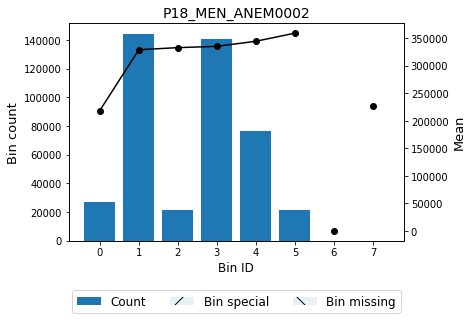

In [34]:

optb.binning_table.plot()



In [ ]:
df['clean_code_commune'].nunique()

In [ ]:
df.at[18,'main_type_terrain']

In [ ]:
df['main_type_terrain'].value_counts()df['main_type_terrain'][0]

In [ ]:
from datetime import datetime
import requests
import pickle

In [ ]:
        categorical_features = [
            "type_de_voie", "clean_code_departement", "clean_code_commune",
            "code_postal", "main_type_terrain", "Dependance", "month"
        ]
        numerical_features = [
            "surface_terrain", "surface_reelle_bati", "nb_pieces_principales",'Taux_RP', 'Taux_LV', 'Taux_MAI',
       'Taux_RP_1P', 'Taux_RP_2P', 'Taux_RP_3P', 'Taux_RP_4P', 'Taux_RP_5P',
       'Taux_RP_30', 'Taux_RP_40', 'Taux_RP_60', 'Taux_RP_80', 'Taux_RP_100',
       'Taux_RP_120', 'Taux_RP_P120', 'Taux_RP_GAR', 'Taux_RP_PROPRIO',
       'Taux_RP_GRATUIT', 'Taux_RP_LOC', 'Taux_RP_HML', 'Taux_RP_AM02',
       'Taux_RP_AM04', 'Taux_RP_AM09', 'Taux_RP_AM09P','Taux_1524',
       'Taux_2554', 'Taux_5564', 'Taux_P_Act', 'Taux_P_ActOct', 'Taux_P_CHO',
       'Taux_CS1', 'Taux_CS2', 'Taux_CS3', 'Taux_CS4', 'Taux_Travail_Commune',
       'Taux_TT', 'Taux_Mar', 'Taux_Velo', 'Taux_2Roues', 'Taux_Voit',
       'Taux_TCOM'
        ]

In [ ]:
filename = 'house_dep_model_aggregations_logement_act.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result=loaded_model.predict(df)

In [2]:
import requests
 

In [3]:
url ='https://api-adresse.data.gouv.fr/search/?q=42+rue=turenne&limit=15'

In [4]:
requests.get(url).json()

{'type': 'FeatureCollection',
 'version': 'draft',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-0.582833, 44.845789]},
   'properties': {'label': '42 Rue Turenne 33000 Bordeaux',
    'score': 0.8946181818181818,
    'housenumber': '42',
    'id': '33063_9115_00042',
    'name': '42 Rue Turenne',
    'postcode': '33000',
    'citycode': '33063',
    'x': 416994.98,
    'y': 6422712.79,
    'city': 'Bordeaux',
    'context': '33, Gironde, Nouvelle-Aquitaine',
    'type': 'housenumber',
    'importance': 0.8408,
    'street': 'Rue Turenne'}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [4.073029, 48.293806]},
   'properties': {'label': '42 Rue Turenne 10000 Troyes',
    'score': 0.8819545454545454,
    'housenumber': '42',
    'id': '10387_5180_00042',
    'name': '42 Rue Turenne',
    'postcode': '10000',
    'citycode': '10387',
    'x': 779579.91,
    'y': 6799815.93,
    'city': 'Troyes',
    'context': '10, Aube, Grand 